In [1]:
# NOTEBOOK SETTINGS
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.rendered_html { font-size: 16px; }</style>"))
display(HTML("<style>table {float:left}</style>"))
import warnings
warnings.filterwarnings('ignore')
import matplotlib
%matplotlib inline
%config Completer.use_jedi = False

<img src="Alpha Data.png" style="width: 300px;"/>

<center><b>ALPHA DATA<b/><center/>

# Beer Sales Forecasting
#### By Fatih, Leo, and Guia

In this notebook, only the models that gave the best results are presented to be used in the future for making forecasts.<br><br>
Overview:
- Regular Sales 
    - With Covid
    - Without Covid
- Online Sales
    - With Covid
    - Without Covid

In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import PercentFormatter
from datetime import datetime, date
import time
import random
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from fbprophet import Prophet
import statsmodels.api as sm
%matplotlib inline

import lightgbm as lgb
import numpy as np
import pandas as pd

from fbprophet import Prophet
from pmdarima import auto_arima
from statsmodels.tsa.stattools import kpss

myfavouritenumber = 13
seed = myfavouritenumber
np.random.seed(seed)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Data Preprocessing

In [3]:
ts_sales_tot = pd.read_csv("ts_sales_tot.csv")
del ts_sales_tot['Unnamed: 0']
del ts_sales_tot['GBP/PIB']
ts_sales_online = pd.read_csv("ts_sales_online.csv")
del ts_sales_online['Unnamed: 0']
del ts_sales_online['GBP/PIB']
ts_sales_online['Period'] = ts_sales_tot['Period']

ts_sales_tot.set_index("Period", drop=False, inplace=True)
display(ts_sales_tot.head(4))
ts_sales_online.set_index("Period", drop=False, inplace=True)
display(ts_sales_online.head(4))

,VENTAS_VALOR,ICC,IPC,UNEMPLOYMENT_RATE,tot_cases,TEMP_MEDIA,PRECIPITACION,Period
Period,,,,,,,,
05/01/2020,40351728.0,0.872,0.011,0.1441,60,6.2340,0.1196,05/01/2020
12/01/2020,28516229.0,0.872,0.011,0.1441,162,6.2456,0.3722,12/01/2020
19/01/2020,33386018.0,0.872,0.011,0.1441,93,7.4634,2.4042,19/01/2020
26/01/2020,30358309.0,0.872,0.011,0.1441,17,6.8302,5.7946,26/01/2020


,VENTAS_VALOR_ONLINE,ICC,IPC,UNEMPLOYMENT_RATE,tot_cases,TEMP_MEDIA,PRECIPITACION,Period
Period,,,,,,,,
05/01/2020,194645.0,0.872,0.011,0.1441,60,6.2340,0.1196,05/01/2020
12/01/2020,198763.0,0.872,0.011,0.1441,162,6.2456,0.3722,12/01/2020
19/01/2020,226645.0,0.872,0.011,0.1441,93,7.4634,2.4042,19/01/2020
26/01/2020,213221.0,0.872,0.011,0.1441,17,6.8302,5.7946,26/01/2020


### Feature Engineering

In [4]:
ts_sales_tot_ = ts_sales_tot
ts_sales_online_ = ts_sales_online

In [5]:
ts_sales_tot_.reset_index(drop=True, inplace=True)
lag_features = ["ICC", "IPC", "UNEMPLOYMENT_RATE", "tot_cases", "TEMP_MEDIA", "PRECIPITACION"]
window1 = 7

df_rolled_7d = ts_sales_tot_[lag_features].rolling(window=window1, min_periods=0)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)


for feature in lag_features:
    ts_sales_tot_[f"{feature}_mean_lag{window1}"] = df_mean_7d[feature]
    ts_sales_tot_[f"{feature}_std_lag{window1}"] = df_std_7d[feature]

ts_sales_tot_.dropna(inplace=True)
ts_sales_tot_.set_index("Period", drop=False, inplace=True)
ts_sales_tot_.tail()

,VENTAS_VALOR,ICC,IPC,UNEMPLOYMENT_RATE,tot_cases,TEMP_MEDIA,PRECIPITACION,Period,ICC_mean_lag7,ICC_std_lag7,IPC_mean_lag7,IPC_std_lag7,UNEMPLOYMENT_RATE_mean_lag7,UNEMPLOYMENT_RATE_std_lag7,tot_cases_mean_lag7,tot_cases_std_lag7,TEMP_MEDIA_mean_lag7,TEMP_MEDIA_std_lag7,PRECIPITACION_mean_lag7,PRECIPITACION_std_lag7
Period,,,,,,,,,,,,,,,,,,,,
13/12/2020,40895963.0,0.631,-0.005,0.1626,56589,7.8008,1.1798,13/12/2020,0.547000,0.050239,-0.007571,0.001134,0.1626,0.0,98854.570312,40274.937500,10.633429,2.168170,2.774143,1.808317
20/12/2020,43541723.0,0.631,-0.005,0.1626,68674,4.7662,3.0916,20/12/2020,0.567857,0.050515,-0.007143,0.001464,0.1626,0.0,86624.000000,37843.113281,9.801400,1.933656,2.199800,1.525733
27/12/2020,46715677.0,0.631,-0.005,0.1626,72478,2.5076,4.8992,27/12/2020,0.588714,0.039555,-0.006714,0.001604,0.1626,0.0,76023.289062,28762.126953,8.673486,2.262053,2.473600,1.482536
03/01/2021,45893775.0,0.631,-0.005,0.1626,100803,3.8076,3.9020,03/01/2021,0.599286,0.039555,-0.006286,0.001604,0.1626,0.0,68110.000000,17557.537109,7.344400,2.784149,3.145800,1.336074
10/01/2021,35019911.0,0.631,-0.005,0.1626,162764,3.8076,3.9020,10/01/2021,0.609857,0.036108,-0.005857,0.001464,0.1626,0.0,67998.710938,17310.753906,6.475572,2.806445,3.200086,1.361387


In [6]:
ts_sales_online_.reset_index(drop=True, inplace=True)
lag_features = ["ICC", "IPC", "UNEMPLOYMENT_RATE", "tot_cases", "TEMP_MEDIA", "PRECIPITACION"]
window1 = 7

df_rolled_7d = ts_sales_online_[lag_features].rolling(window=window1, min_periods=0)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)


for feature in lag_features:
    ts_sales_online_[f"{feature}_mean_lag{window1}"] = df_mean_7d[feature]
    ts_sales_online_[f"{feature}_std_lag{window1}"] = df_std_7d[feature]

ts_sales_online_.dropna(inplace=True)
ts_sales_online_.set_index("Period", drop=False, inplace=True)
ts_sales_online_.head()

,VENTAS_VALOR_ONLINE,ICC,IPC,UNEMPLOYMENT_RATE,tot_cases,TEMP_MEDIA,PRECIPITACION,Period,ICC_mean_lag7,ICC_std_lag7,IPC_mean_lag7,IPC_std_lag7,UNEMPLOYMENT_RATE_mean_lag7,UNEMPLOYMENT_RATE_std_lag7,tot_cases_mean_lag7,tot_cases_std_lag7,TEMP_MEDIA_mean_lag7,TEMP_MEDIA_std_lag7,PRECIPITACION_mean_lag7,PRECIPITACION_std_lag7
Period,,,,,,,,,,,,,,,,,,,,
19/01/2020,226645.0,0.872,0.011,0.1441,93,7.4634,2.4042,19/01/2020,0.872,0.000000,0.011000,0.000000,0.1441,0.0,111.000000,72.124893,6.239800,0.008202,0.245900,0.178615
26/01/2020,213221.0,0.872,0.011,0.1441,17,6.8302,5.7946,26/01/2020,0.872,0.000000,0.011000,0.000000,0.1441,0.0,105.000000,52.048054,6.647666,0.706470,0.965333,1.252479
02/02/2020,226867.0,0.857,0.007,0.1441,70,10.0550,0.4274,02/02/2020,0.872,0.000000,0.011000,0.000000,0.1441,0.0,83.000000,61.171890,6.693300,0.584006,2.172650,2.622262
09/02/2020,230472.0,0.857,0.007,0.1441,73,9.9284,0.4658,09/02/2020,0.869,0.006708,0.010200,0.001789,0.1441,0.0,80.400002,53.294464,7.365640,1.586191,1.823600,2.401327
16/02/2020,227544.0,0.857,0.007,0.1441,173,11.2848,1.5786,16/02/2020,0.867,0.007746,0.009667,0.002066,0.1441,0.0,79.166664,47.763653,7.792767,1.762789,1.597300,2.218190


In [7]:
ts_sales_tot_['Period'] = pd.to_datetime(ts_sales_tot_['Period'],dayfirst=True)
df_train_tot = ts_sales_tot_[ts_sales_tot_.Period < pd.to_datetime('01/12/2020',dayfirst=True)]
df_valid_tot = ts_sales_tot_[ts_sales_tot_.Period >= pd.to_datetime('01/12/2020',dayfirst=True)]

exogenous_features2 =  ['ICC_mean_lag7',
       'ICC_std_lag7', 'IPC_mean_lag7', 'IPC_std_lag7',
       'UNEMPLOYMENT_RATE_mean_lag7', 'UNEMPLOYMENT_RATE_std_lag7',
       'tot_cases_mean_lag7', 'tot_cases_std_lag7', 'TEMP_MEDIA_mean_lag7',
       'TEMP_MEDIA_std_lag7', 'PRECIPITACION_mean_lag7',
       'PRECIPITACION_std_lag7']

In [8]:
ts_sales_online_['Period'] = pd.to_datetime(ts_sales_online_['Period'],dayfirst=True)
df_train_online = ts_sales_online_[ts_sales_online_.Period < pd.to_datetime('01/12/2020',dayfirst=True)]
df_valid_online = ts_sales_online_[ts_sales_online_.Period >= pd.to_datetime('01/12/2020',dayfirst=True)]

exogenous_features =  ['ICC_mean_lag7',
       'ICC_std_lag7', 'IPC_mean_lag7', 'IPC_std_lag7',
       'UNEMPLOYMENT_RATE_mean_lag7', 'UNEMPLOYMENT_RATE_std_lag7',
       'tot_cases_mean_lag7', 'tot_cases_std_lag7', 'TEMP_MEDIA_mean_lag7',
       'TEMP_MEDIA_std_lag7', 'PRECIPITACION_mean_lag7',
       'PRECIPITACION_std_lag7']

### Feature Importance / Selection

#### Regular Sales

[0.09276522 0.18631172 0.05952342 0.00941203 0.01467015 0.00910187
 0.19462473 0.04675744 0.2883928  0.01485979 0.02687624 0.05670458]


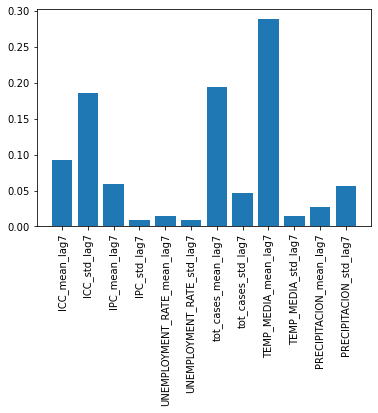

In [9]:
X = ts_sales_tot_[exogenous_features2]
y = ts_sales_tot_["VENTAS_VALOR"]

model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X, y)
# show importance scores
print(model.feature_importances_)
# plot importance scores
names = X.columns.values
ticks = [i for i in range(len(names))]
plt.bar(ticks, model.feature_importances_)
plt.xticks(ticks, names, rotation='vertical')
plt.show()

#### Online Sales

[0.31222959 0.00982091 0.31099667 0.0234745  0.13205629 0.00241221
 0.0981783  0.0318752  0.02431774 0.019461   0.02015487 0.01502273]


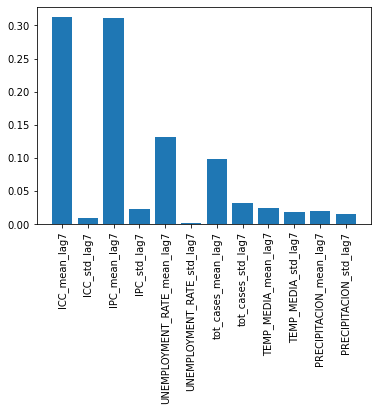

In [10]:
X_ = ts_sales_online_[exogenous_features]
y_ = ts_sales_online_["VENTAS_VALOR_ONLINE"]

model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X_, y_)
# show importance scores
print(model.feature_importances_)
# plot importance scores
names = X.columns.values
ticks = [i for i in range(len(names))]
plt.bar(ticks, model.feature_importances_)
plt.xticks(ticks, names, rotation='vertical')
plt.show()

### Forecasting Regular Sales in Spain

In [13]:
selected_features = ["tot_cases_mean_lag7","TEMP_MEDIA_mean_lag7","ICC_mean_lag7"]

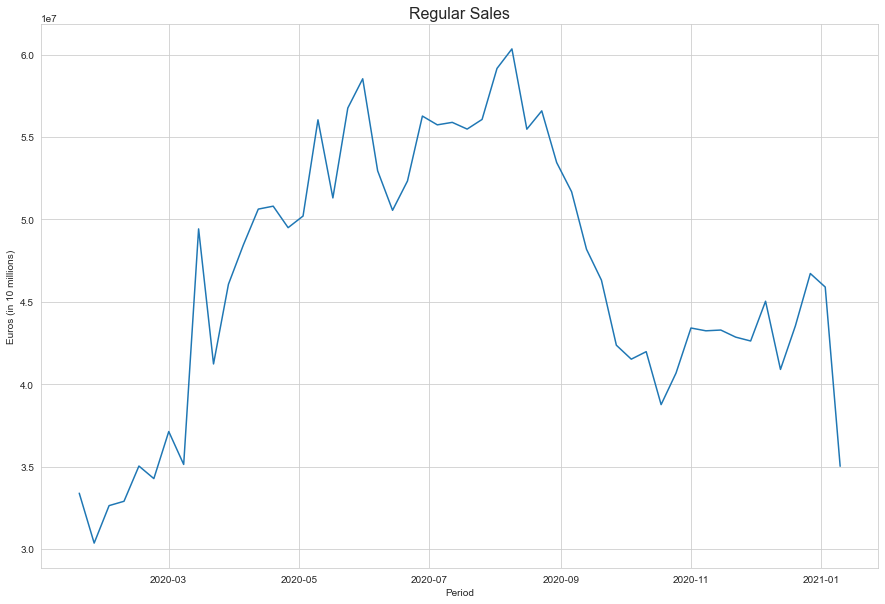

In [212]:
sns.set_style('whitegrid')
fig, ax1 = plt.subplots(figsize=(15,10))
sns.lineplot(data=ts_sales_tot, y='VENTAS_VALOR', x='Period')
plt.ylabel('Euros (in 10 millions)')
plt.title('Regular Sales',fontsize=16);

#### ARIMAX

In [152]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(df_train_tot.VENTAS_VALOR)

KPSS Statistic: 0.18768792574389506
p-value: 0.1
num lags: 10
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\leofr\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [14]:
# ARIMA tot
model = auto_arima(df_train_tot.VENTAS_VALOR, exogenous=df_train_tot[selected_features], trace=True, 
                   error_action="ignore", suppress_warnings=True)
model.fit(df_train_tot.VENTAS_VALOR, exogenous=df_train_tot[selected_features])

forecast = model.predict(n_periods=len(df_valid_tot), exogenous=df_valid_tot[selected_features])
df_valid_tot["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1522.478, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1585.147, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1530.626, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1566.509, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1714.418, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1527.768, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1528.820, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1530.265, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1529.238, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1522.347, Time=0.25 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1528.814, Time=0.11 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=1521.784, Time=0.24 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=1

C:\Users\leofr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [15]:
print('RMSE:',np.round(np.sqrt(mean_squared_error(df_valid_tot['VENTAS_VALOR'], df_valid_tot['Forecast_ARIMAX'])),2))

RMSE: 3728755.95


In [297]:
print('MAPE:',np.round(mean_absolute_percentage_error(df_valid_tot['VENTAS_VALOR'], df_valid_tot['Forecast_ARIMAX']),2))

MAPE: 7.86


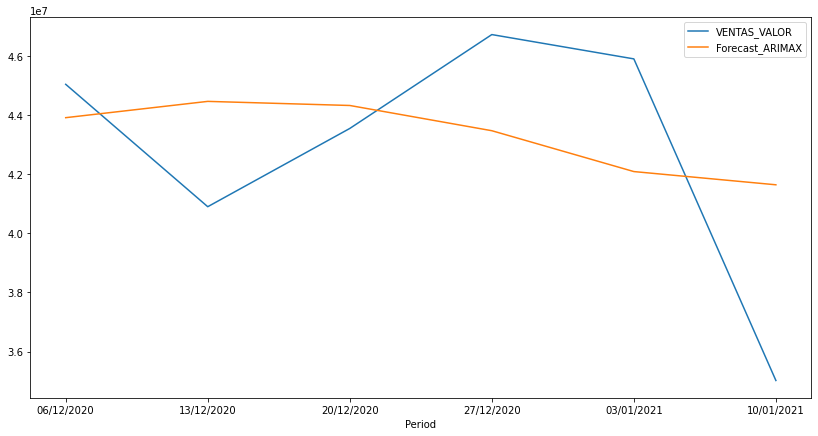

In [16]:
df_valid_tot[["VENTAS_VALOR", "Forecast_ARIMAX"]].plot(figsize=(14, 7));

#### Prophet

In [55]:
# PROPHET tot
model_fbp = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False, changepoint_prior_scale=0.5, seasonality_mode='additive')
model_fbp.add_country_holidays(country_name='Spain')
for feature in selected_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train_tot[["Period", "VENTAS_VALOR"] + selected_features].rename(columns={"Period": "ds", "VENTAS_VALOR": "y"}))

forecast = model_fbp.predict(df_valid_tot[["Period", "VENTAS_VALOR"] + selected_features].rename(columns={"Period": "ds"}))
df_valid_tot["Forecast_Prophet"] = forecast.yhat.values

In [56]:
print('RMSE:',np.round(np.sqrt(mean_squared_error(df_valid_tot['VENTAS_VALOR'], df_valid_tot['Forecast_Prophet'])),2))

RMSE: 7250259.28


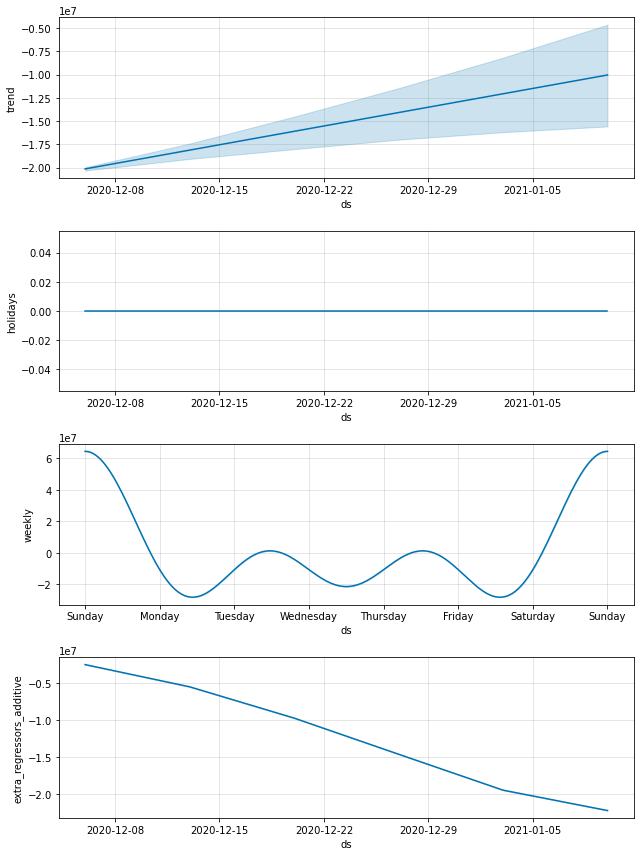

In [33]:
fig = model_fbp.plot_components(forecast)

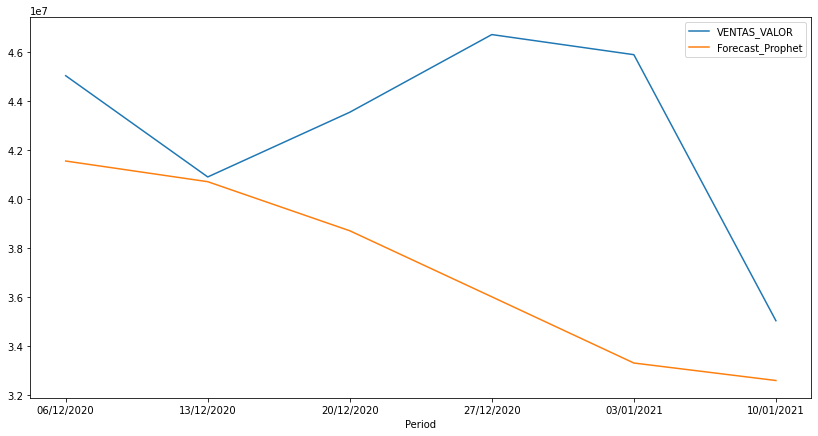

In [57]:
df_valid_tot[["VENTAS_VALOR", "Forecast_Prophet"]].plot(figsize=(14, 7));

#### LightGBM

In [145]:
# LightGBM tot
params = {"objective": "regression"}

dtrain = lgb.Dataset(df_train_tot[selected_features], label=df_train_tot.VENTAS_VALOR.values)
dvalid = lgb.Dataset(df_valid_tot[selected_features])

model_lgb = lgb.train(params, train_set=dtrain)

forecast = model_lgb.predict(df_valid_tot[selected_features])
df_valid_tot["Forecast_LightGBM"] = forecast

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 3
[LightGBM] [Info] Start training from score 47106539.652174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [146]:
print('RMSE:',np.round(np.sqrt(mean_squared_error(df_valid_tot['VENTAS_VALOR'], df_valid_tot['Forecast_LightGBM'])),2))

RMSE: 4545838.56


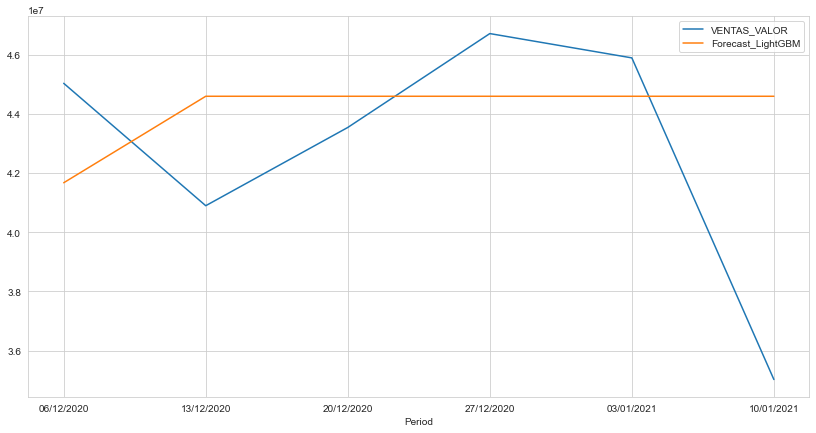

In [147]:
df_valid_tot[["VENTAS_VALOR", "Forecast_LightGBM"]].plot(figsize=(14, 7));

#### All Combined

In [222]:
df_valid_tot['Combined'] = (df_valid_tot.Forecast_ARIMAX + df_valid_tot.Forecast_Prophet + df_valid_tot.Forecast_LightGBM) / 3
print('RMSE:',np.round(np.sqrt(mean_squared_error(df_valid_tot['VENTAS_VALOR'], df_valid_tot['Combined'])),2))

RMSE: 4046565.42


<AxesSubplot:xlabel='Period'>

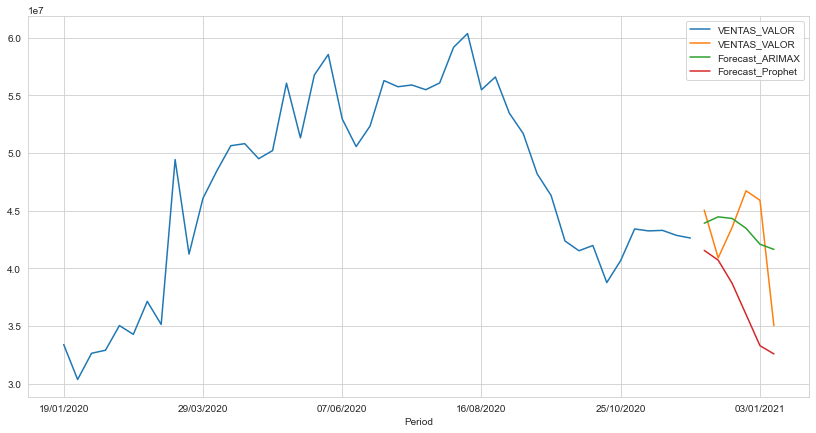

In [220]:
sns.set_style('whitegrid')
pd.concat([df_train_tot.VENTAS_VALOR,df_valid_tot.VENTAS_VALOR,df_valid_tot.Forecast_ARIMAX,df_valid_tot.Forecast_Prophet], axis=1).plot(figsize=(14, 7))

### Cross-Validation

In [133]:
total_sales = ts_sales_tot.copy(deep=True)
total_sales.Period = total_sales.Period.astype(np.datetime64)
total_sales.set_index("Period", drop=False, inplace=True)

sales = total_sales.reset_index(drop=True)
X = total_sales.reset_index(drop=True).drop('VENTAS_VALOR',1)
y = total_sales.reset_index(drop=True)['VENTAS_VALOR']

In [137]:
# Cross_Validation ARIMAX
tscv = TimeSeriesSplit(n_splits=5)

score = []
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = auto_arima(y_train, exogenous=X_train[selected_features], trace=True, 
                   error_action="ignore", suppress_warnings=True)
    model.fit(y_train, exogenous=X_train[selected_features])
    forecast = model.predict(n_periods=len(X_test), exogenous=X_test[selected_features])

    score.append(np.round(np.sqrt(mean_squared_error(y_test, forecast)),2))

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12 13 14 15 16 17 18 19]
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=402.398, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=399.868, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=399.304, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=419.217, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=400.678, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=402.556, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=399.797, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=398.007, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=399.768, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=397.931, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=399.717, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4

In [138]:
np.mean(score)

9028415.672

In [218]:
# Cross_Validation Prophet
tscv = TimeSeriesSplit(n_splits=5)

score2 = []
for train_index, test_index in tscv.split(sales):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = sales.iloc[train_index], sales.iloc[test_index]
    
    model_fbp = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False, changepoint_prior_scale=0.5, seasonality_mode='additive')
    model_fbp.add_country_holidays(country_name='Spain')
    for feature in selected_features:
        model_fbp.add_regressor(feature)

    model_fbp.fit(X_train[["Period", "VENTAS_VALOR"] + selected_features].rename(columns={"Period": "ds", "VENTAS_VALOR": "y"}))

    forecast = model_fbp.predict(X_test[["Period", "VENTAS_VALOR"] + selected_features].rename(columns={"Period": "ds"}))

    score2.append(np.round(np.sqrt(mean_squared_error(y_test, forecast.yhat.values)),2))

INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12 13 14 15 16 17 18 19]


INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24 25 26 27]


INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] TEST: [28 29 30 31 32 33 34 35]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] TEST: [36 37 38 39 40 41 42 43]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43] TEST: [44 45 46 47 48 49 50 51]


In [219]:
np.mean(score2)

15454862.39

#### ARIMAX performs best on this data, but Prophet can handle the holiday effects much better when having the entire data and not having to predict on previously unseen events like in the traintest split or cross-validation. Therefore, both models will be combined to make the predictions for the year of 2021. However, Prophet will be more used to fit the holdiays and seasonality better.

Predicting Exogenous Variables:

In [235]:
future_df = pd.DataFrame({'Period':np.array('2021-01-17', dtype=np.datetime64) + np.arange(0,360,7)})
future_df.set_index("Period", drop=False, inplace=True)

for i in ["tot_cases_mean_lag7","ICC_mean_lag7"]:
    model = auto_arima(total_sales[i], trace=True, error_action="ignore", suppress_warnings=True, seasonality=True, m=12)
    model.fit(total_sales[i])
    forecast = model.predict(n_periods=52)
    future_df[i] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=917.833, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1022.247, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=944.374, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1023.447, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=916.500, Time=0.26 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=914.534, Time=0.04 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=915.930, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=917.386, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=912.080, Time=0.02 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=914.068, Time=0.05 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=914.047, Time=0.19 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=915.426, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=924.813, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept 

In [237]:
future_df['TEMP_MEDIA_mean_lag7'] = total_sales['TEMP_MEDIA_mean_lag7'].values

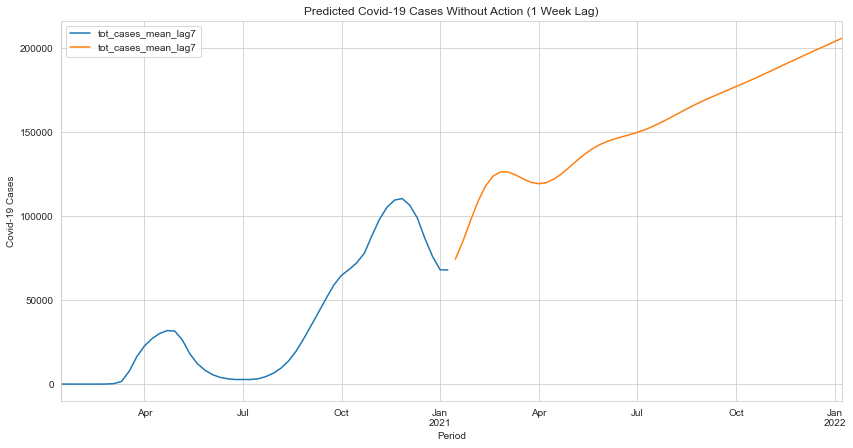

In [352]:
sns.set_style('whitegrid')
pd.concat([total_sales.tot_cases_mean_lag7, future_df.tot_cases_mean_lag7], axis=1).plot(figsize=(14, 7),title='Predicted Covid-19 Cases Without Action (1 Week Lag)',ylabel='Covid-19 Cases');

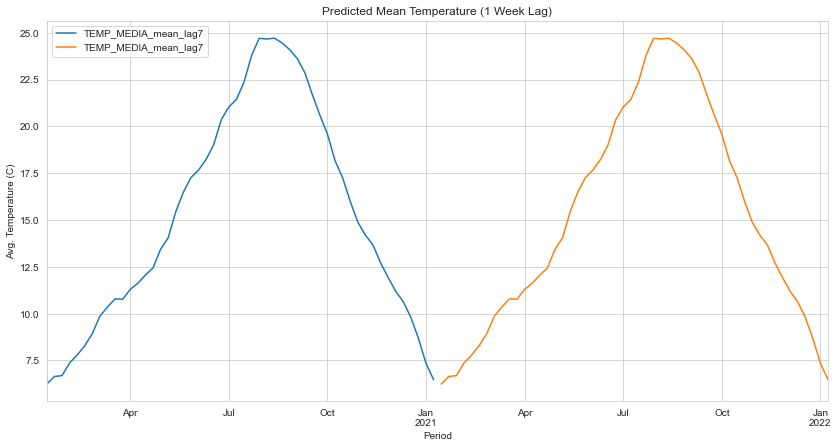

In [353]:
pd.concat([total_sales.TEMP_MEDIA_mean_lag7, future_df.TEMP_MEDIA_mean_lag7], axis=1).plot(figsize=(14, 7),title='Predicted Mean Temperature (1 Week Lag)',ylabel='Avg. Temperature (C)');

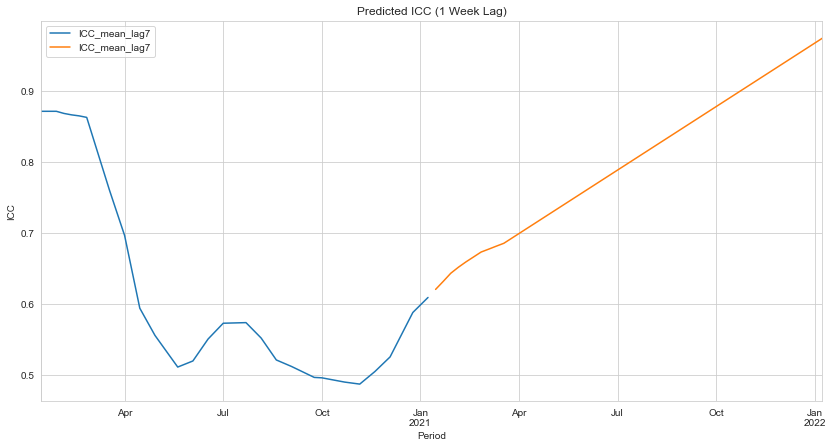

In [354]:
pd.concat([total_sales.ICC_mean_lag7, future_df.ICC_mean_lag7], axis=1).plot(figsize=(14, 7),title='Predicted ICC (1 Week Lag)', ylabel='ICC');

#### Final Forecast

In [265]:
# PROPHET tot
model_fbp = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True, changepoint_prior_scale=0.5, seasonality_mode='additive')
model_fbp.add_country_holidays(country_name='Spain')
for feature in selected_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(total_sales[["Period", "VENTAS_VALOR"] + selected_features].rename(columns={"Period": "ds", "VENTAS_VALOR": "y"}))

forecast = model_fbp.predict(total_sales[["Period", "VENTAS_VALOR"] + selected_features].rename(columns={"Period": "ds"}))
future_df["Forecast_Prophet"] = forecast.yhat.values
interval_low_p = forecast.yhat_lower
interval_high_p = forecast.yhat_upper

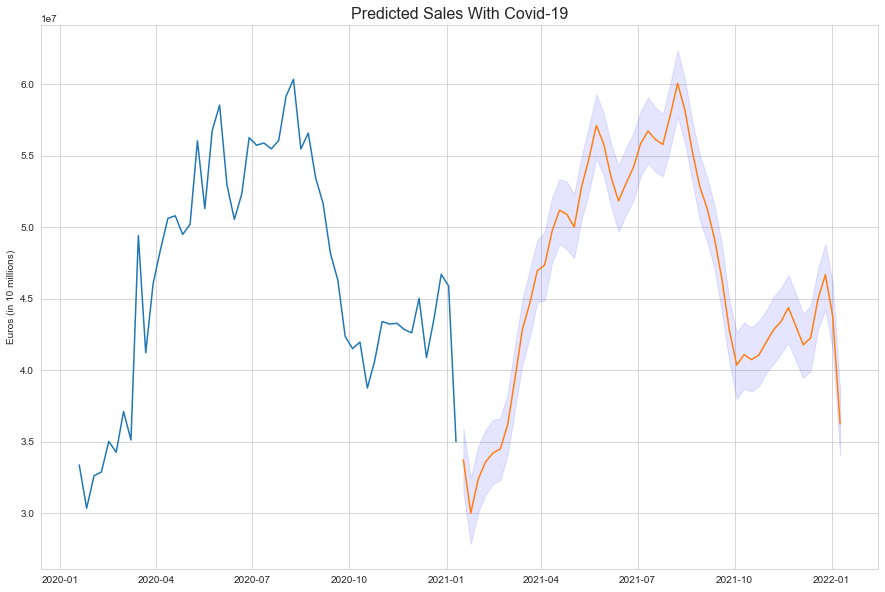

In [266]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15,10))
ax.fill_between(future_df.index, interval_low_p, interval_high_p, color='b', alpha=0.1)
ax.plot(pd.concat([total_sales.VENTAS_VALOR, future_df.Forecast_Prophet], axis=1))
plt.ylabel('Euros (in 10 millions)')
plt.title('Predicted Sales With Covid-19',fontsize=16);

In [250]:
model = auto_arima(total_sales.VENTAS_VALOR, exogenous=total_sales[selected_features], trace=True, 
                   error_action="ignore", suppress_warnings=True, seasonality=True)
model.fit(total_sales.VENTAS_VALOR, exogenous=total_sales[selected_features])

forecast, interval = model.predict(n_periods=len(future_df), exogenous=future_df[selected_features], return_conf_int=True,alpha=0.05)
future_df["Forecast_ARIMAX"] = forecast

interval_low_a = [item[0] for item in interval]
interval_high_a = [item[1] for item in interval]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1727.116, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1792.118, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1733.478, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1769.292, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1944.753, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1733.153, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1733.463, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1736.358, Time=0.13 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1719.542, Time=0.23 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1733.510, Time=0.09 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=1721.035, Time=0.32 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=1732.512, Time=0.16 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1

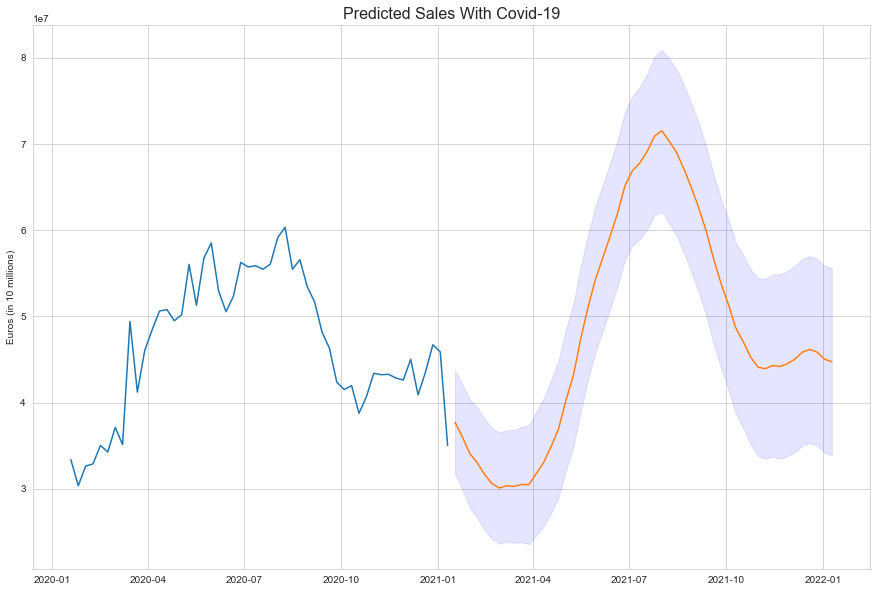

In [251]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15,10))
ax.fill_between(future_df.index, interval_low_a, interval_high_a, color='b', alpha=.1)
ax.plot(pd.concat([total_sales.VENTAS_VALOR, future_df.Forecast_ARIMAX], axis=1))
plt.ylabel('Euros (in 10 millions)')
plt.title('Predicted Sales With Covid-19',fontsize=16);

#### Combined

In [273]:
future_df['Combind_Prophet_ARIMAX'] = (future_df.Forecast_ARIMAX + future_df.Forecast_Prophet) / 2
con_low = (interval_low_p + interval_low_a) / 2
con_high = (interval_high_p + interval_high_a) / 2

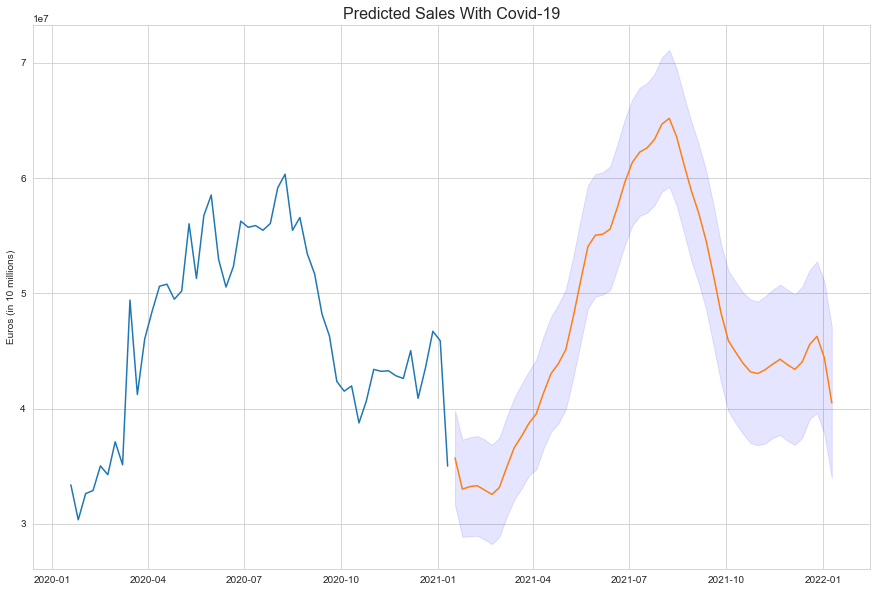

In [274]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15,10))
ax.fill_between(future_df.index, con_low, con_high, color='b', alpha=.1)
ax.plot(pd.concat([total_sales.VENTAS_VALOR, future_df.Combind_Prophet_ARIMAX], axis=1))
plt.ylabel('Euros (in 10 millions)')
plt.title('Predicted Sales With Covid-19',fontsize=16);

##### NO COVID

In [280]:
future_df['tot_cases_mean_lag7'] = np.repeat(0,52)

In [281]:
# PROPHET tot
model_fbp = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True, changepoint_prior_scale=0.5, seasonality_mode='additive')
model_fbp.add_country_holidays(country_name='Spain')
for feature in selected_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(total_sales[["Period", "VENTAS_VALOR"] + selected_features].rename(columns={"Period": "ds", "VENTAS_VALOR": "y"}))

forecast = model_fbp.predict(total_sales[["Period", "VENTAS_VALOR"] + selected_features].rename(columns={"Period": "ds"}))
future_df["Forecast_Prophet_no_covid"] = forecast.yhat.values
interval_low_p = forecast.yhat_lower
interval_high_p = forecast.yhat_upper

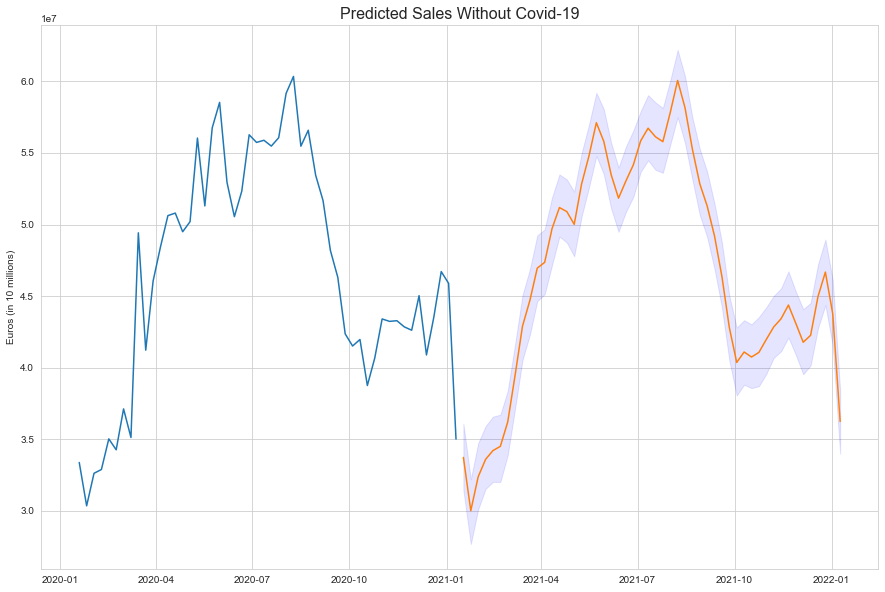

In [282]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15,10))
ax.fill_between(future_df.index, interval_low_p, interval_high_p, color='b', alpha=0.1)
ax.plot(pd.concat([total_sales.VENTAS_VALOR, future_df.Forecast_Prophet_no_covid], axis=1))
plt.ylabel('Euros (in 10 millions)')
plt.title('Predicted Sales Without Covid-19',fontsize=16);

In [283]:
model = auto_arima(total_sales.VENTAS_VALOR, exogenous=total_sales[selected_features], trace=True, 
                   error_action="ignore", suppress_warnings=True, seasonality=True)
model.fit(total_sales.VENTAS_VALOR, exogenous=total_sales[selected_features])

forecast2, interval2 = model.predict(n_periods=len(future_df), exogenous=future_df[selected_features], return_conf_int=True,alpha=0.05)
future_df["Forecast_ARIMAX_no_covid"] = forecast2

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1727.116, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1792.118, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1733.478, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1769.292, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1944.753, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1733.153, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1733.463, Time=0.34 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1736.358, Time=0.37 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1719.542, Time=0.58 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1733.510, Time=0.16 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=1721.035, Time=0.75 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=1732.512, Time=0.42 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1

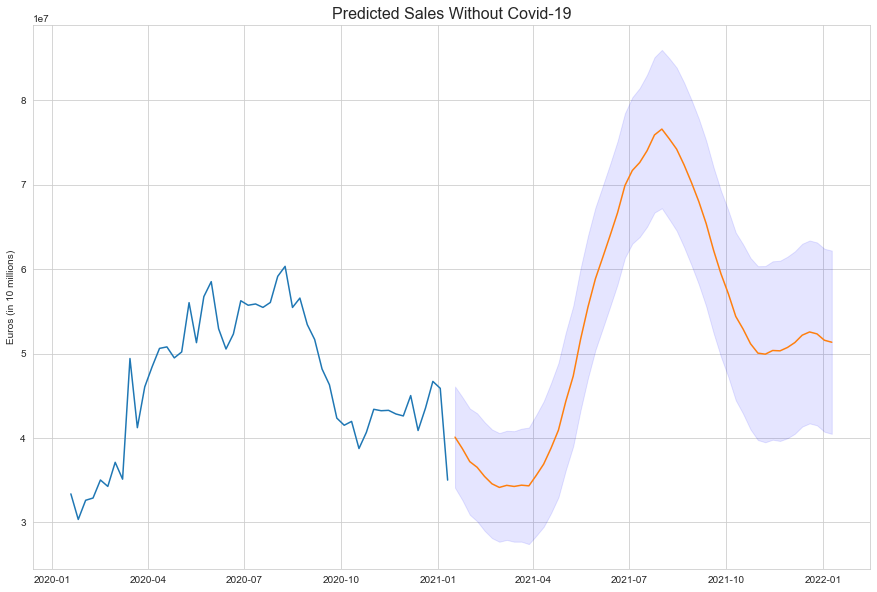

In [284]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15,10))
ax.fill_between(future_df.index, [item[0] for item in interval2], [item[1] for item in interval2], color='b', alpha=.1)
ax.plot(pd.concat([total_sales.VENTAS_VALOR, future_df.Forecast_ARIMAX_no_covid], axis=1))
plt.ylabel('Euros (in 10 millions)')
plt.title('Predicted Sales Without Covid-19',fontsize=16);

#### Combined

In [285]:
future_df['Combind_Prophet_ARIMAX_no_covid'] = (future_df.Forecast_ARIMAX_no_covid + future_df.Forecast_Prophet_no_covid) / 2
con_low = (interval_low_p + interval_low_a) / 2
con_high = (interval_high_p + interval_high_a) / 2

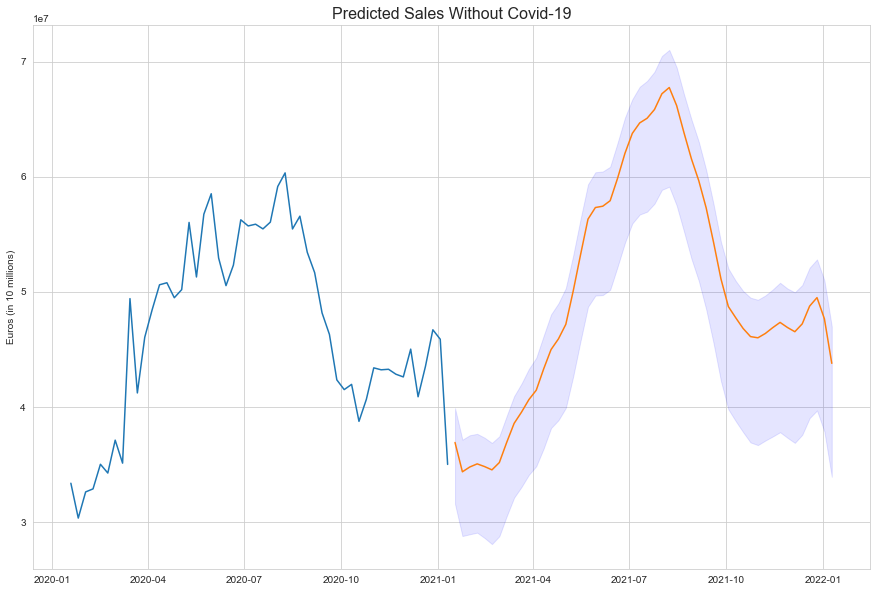

In [286]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15,10))
ax.fill_between(future_df.index, con_low, con_high, color='b', alpha=.1)
ax.plot(pd.concat([total_sales.VENTAS_VALOR, future_df.Combind_Prophet_ARIMAX_no_covid], axis=1))
plt.ylabel('Euros (in 10 millions)')
plt.title('Predicted Sales Without Covid-19',fontsize=16);

#### In Numbers

In [275]:
quarterly_forecast = future_df.groupby(future_df.index.to_period('Q')).agg(
    {'Combind_Prophet_ARIMAX':'sum'})
quarterly_forecast.Combind_Prophet_ARIMAX[0] = quarterly_forecast.Combind_Prophet_ARIMAX[0] + sum(total_sales.VENTAS_VALOR.tail(2).values)
quarterly_forecast.head(4)

,Combind_Prophet_ARIMAX
Period,
2021Q1,4.627070e+08
2021Q2,6.490678e+08
2021Q3,7.744698e+08
2021Q4,5.756006e+08


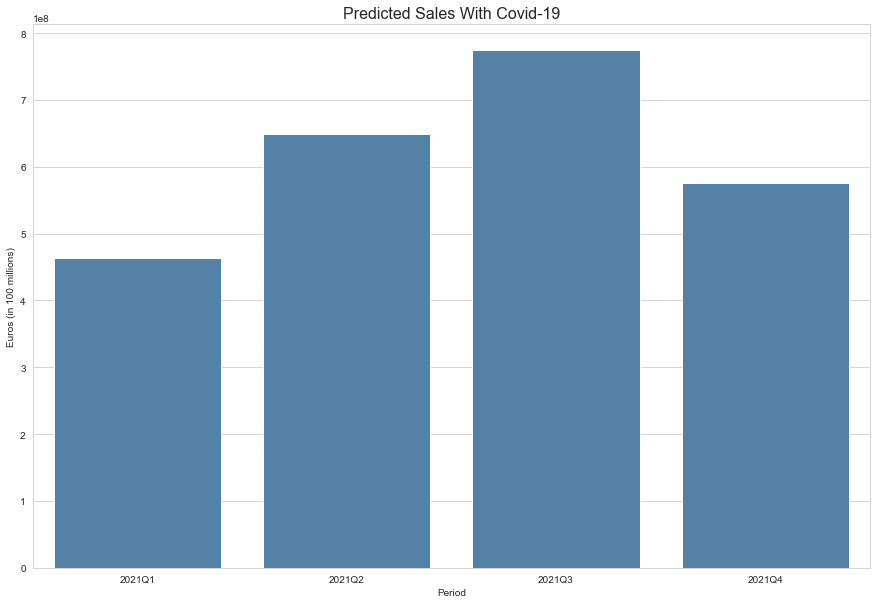

In [276]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=quarterly_forecast.head(4), x=quarterly_forecast.head(4).index, y='Combind_Prophet_ARIMAX', color='steelblue')
plt.ylabel('Euros (in 100 millions)')
plt.title('Predicted Sales With Covid-19',fontsize=16);

In [277]:
yearly_forecast = sum(quarterly_forecast.head(4)['Combind_Prophet_ARIMAX'])
np.round(yearly_forecast)

2461845128.0

In [278]:
# Previous Year (2020)
sum(total_sales.VENTAS_VALOR)

2424001902.0

In [279]:
# Percent Increase
print(np.round((np.round(yearly_forecast - sum(total_sales.VENTAS_VALOR))) * 100 / sum(total_sales.VENTAS_VALOR),1),'% increase from 2020')

1.6 % increase from 2020


In [111]:
# Without Covid
quarterly_forecast2 = future_df.groupby(future_df.index.to_period('Q')).agg(
    {'Combind_Prophet_ARIMAX_no_covid':'sum'})
quarterly_forecast2.Combind_Prophet_ARIMAX_no_covid[0] = quarterly_forecast2.Combind_Prophet_ARIMAX_no_covid[0] + sum(total_sales.VENTAS_VALOR.tail(2).values)
quarterly_forecast2.head(4)

,Combind_Prophet_ARIMAX_no_covid
Period,
2021Q1,4.823805e+08
2021Q2,6.771868e+08
2021Q3,8.083324e+08
2021Q4,6.150786e+08


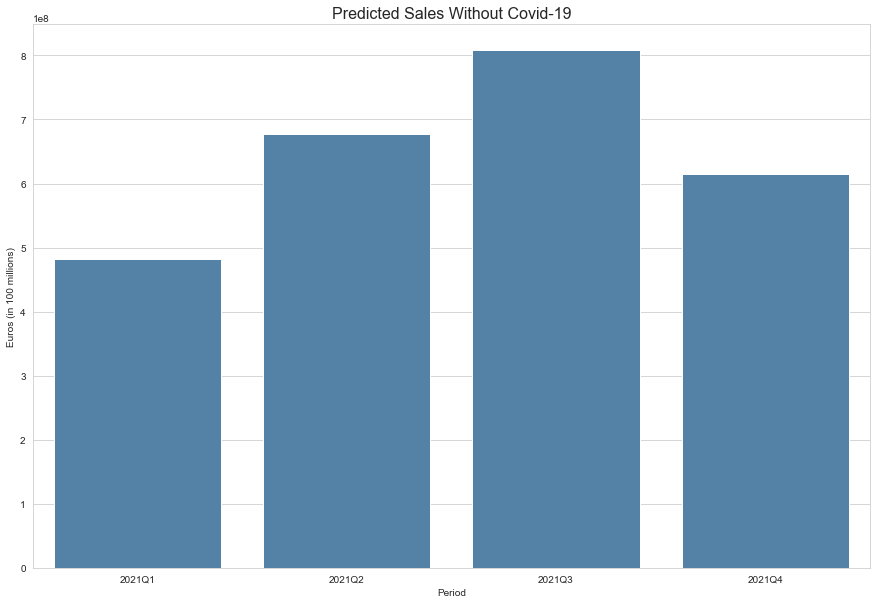

In [113]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=quarterly_forecast2.head(4), x=quarterly_forecast2.head(4).index, y='Combind_Prophet_ARIMAX_no_covid', color='steelblue')
plt.ylabel('Euros (in 100 millions)')
plt.title('Predicted Sales Without Covid-19',fontsize=16);

In [115]:
yearly_forecast2 = sum(quarterly_forecast2.head(4)['Combind_Prophet_ARIMAX_no_covid'])
print('Yearly forecast:',np.round(yearly_forecast2))

# Percent Increase
print(np.round((np.round(yearly_forecast2 - sum(total_sales.VENTAS_VALOR))) * 100 / sum(total_sales.VENTAS_VALOR),1),'% increase from 2020')

Yearly forecast: 2582978195.0
6.6 % increase from 2020


### Forecasting Online Sales in Spain

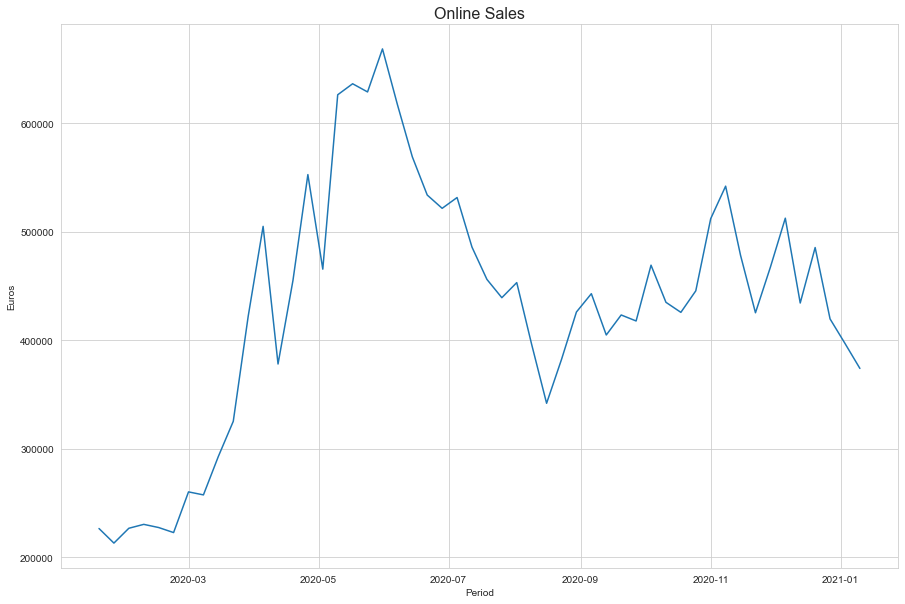

In [214]:
sns.set_style('whitegrid')
fig, ax1 = plt.subplots(figsize=(15,10))
sns.lineplot(data=ts_sales_online, y='VENTAS_VALOR_ONLINE', x='Period')
plt.ylabel('Euros')
plt.title('Online Sales',fontsize=16);

In [434]:
selected_features2 = ['tot_cases_mean_lag7']

In [448]:
kpss_test(df_train_online.VENTAS_VALOR_ONLINE)

KPSS Statistic: 0.20990839168441108
p-value: 0.1
num lags: 10
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\leofr\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [436]:
model = auto_arima(df_train_online.VENTAS_VALOR_ONLINE, exogenous=df_train_online[selected_features2], 
                   trace=True, error_action="ignore", suppress_warnings=True, seasonality=True, m=12, d=1)
model.fit(df_train_online.VENTAS_VALOR_ONLINE, exogenous=df_train_online[selected_features2])

forecast = model.predict(n_periods=len(df_valid_online), exogenous=df_valid_online[selected_features2])
df_valid_online["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1115.842, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1112.174, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1109.015, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1109.120, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1237.581, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1113.159, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1110.718, Time=0.22 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1110.491, Time=0.24 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1108.497, Time=0.15 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1110.492, Time=0.26 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1112.017, Time=0.49 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1108.295, Time=0.10 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1110.295, Time=0.19 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1110.287, Time=0.17 sec
 ARIMA(0,1,0)(1,0,0

C:\Users\leofr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [437]:
print('RMSE:',np.round(np.sqrt(mean_squared_error(df_valid_online['VENTAS_VALOR_ONLINE'], df_valid_online['Forecast_ARIMAX'])),2))

RMSE: 60180.9


In [420]:
print('MAPE:',np.round(mean_absolute_percentage_error(df_valid_online['VENTAS_VALOR_ONLINE'], df_valid_online['Forecast_ARIMAX']),2))

MAPE: 5.84


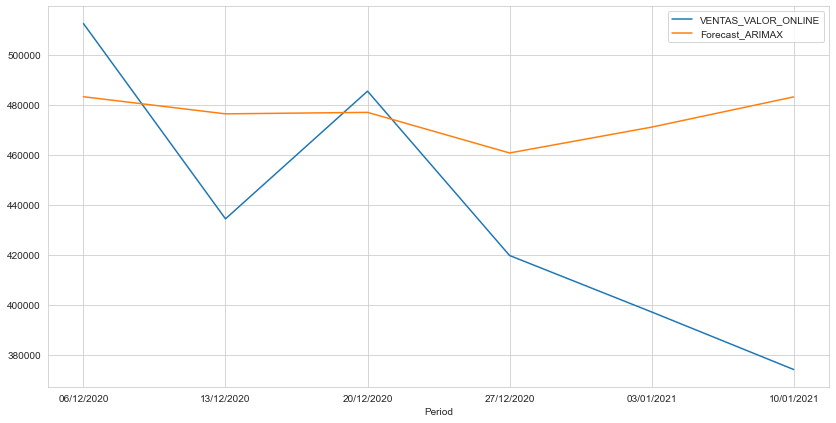

In [438]:
df_valid_online[["VENTAS_VALOR_ONLINE", "Forecast_ARIMAX"]].plot(figsize=(14, 7));

#### Prophet

In [422]:
# PROPHET tot
model_fbp = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False, changepoint_prior_scale=1.3, seasonality_mode='additive')
model_fbp.add_country_holidays(country_name='Spain')
for feature in selected_features2:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train_online[["Period", "VENTAS_VALOR_ONLINE"] + selected_features2].rename(columns={"Period": "ds", "VENTAS_VALOR_ONLINE": "y"}))

forecast = model_fbp.predict(df_valid_online[["Period", "VENTAS_VALOR_ONLINE"] + selected_features2].rename(columns={"Period": "ds"}))
df_valid_online["Forecast_Prophet"] = forecast.yhat.values

In [423]:
print('RMSE:',np.round(np.sqrt(mean_squared_error(df_valid_online['VENTAS_VALOR_ONLINE'], df_valid_online['Forecast_Prophet'])),2))

RMSE: 36910.24


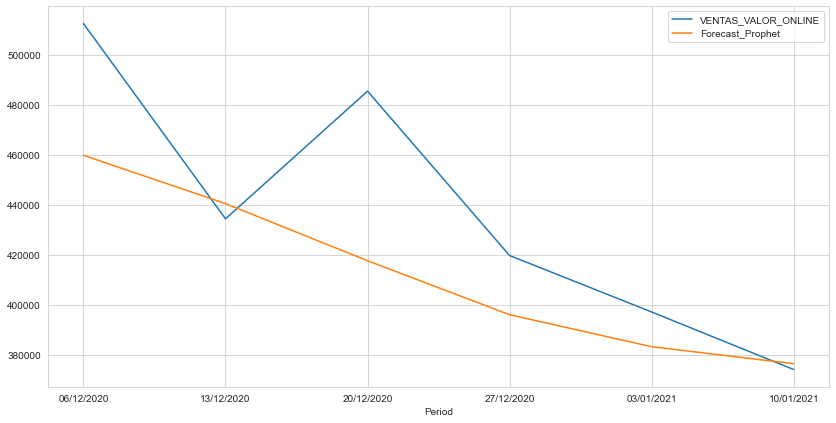

In [424]:
df_valid_online[["VENTAS_VALOR_ONLINE", "Forecast_Prophet"]].plot(figsize=(14, 7));

#### Combined

In [425]:
df_valid_online['Combined'] = (df_valid_online.Forecast_ARIMAX + df_valid_online.Forecast_Prophet) / 2
print('RMSE:',np.round(np.sqrt(mean_squared_error(df_valid_online['VENTAS_VALOR_ONLINE'], df_valid_online['Combined'])),2))

RMSE: 34816.29


#### Predicting Exogenous Variables

In [426]:
total_sales_on = ts_sales_online.copy(deep=True)
total_sales_on.Period = total_sales_on.Period.astype(np.datetime64)
total_sales_on.set_index("Period", drop=False, inplace=True)

In [427]:
future_df_on = pd.DataFrame({'Period':np.array('2021-01-17', dtype=np.datetime64) + np.arange(0,360,7)})
future_df_on.set_index("Period", drop=False, inplace=True)

for i in ["tot_cases_mean_lag7","ICC_mean_lag7",'IPC_mean_lag7']:
    model = auto_arima(total_sales_on[i], trace=True, error_action="ignore", suppress_warnings=True, seasonality=True, m=12)
    model.fit(total_sales_on[i])
    forecast = model.predict(n_periods=52)
    future_df_on[i] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=917.833, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1022.247, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=944.374, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1023.447, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=916.500, Time=0.47 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=914.534, Time=0.07 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=915.930, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=917.386, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=912.080, Time=0.04 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=914.068, Time=0.09 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=914.047, Time=0.24 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=915.426, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=924.813, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept 

In [415]:
m = Prophet(changepoint_prior_scale=0.5)
m.fit(total_sales_on.rename(columns={"Period": "ds","IPC_mean_lag7":"y"}))
future = m.make_future_dataframe(periods=52, include_history=False)
future_df_on.IPC_mean_lag7 = m.predict(future).yhat.values

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


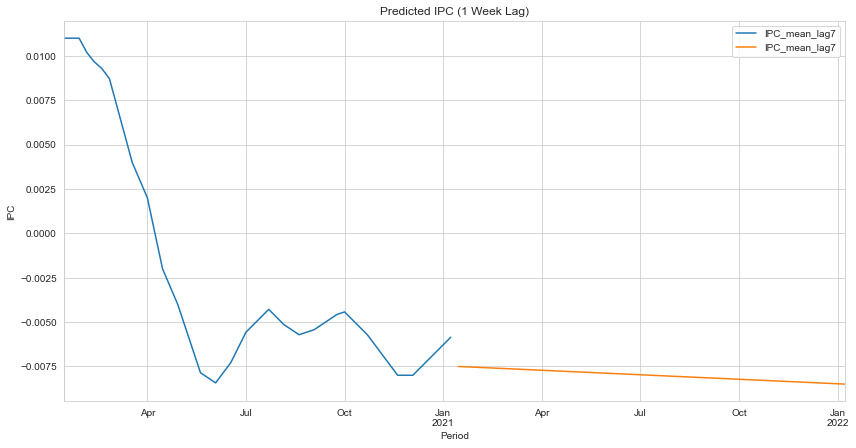

In [416]:
pd.concat([total_sales_on.IPC_mean_lag7, future_df_on.IPC_mean_lag7], axis=1).plot(figsize=(14, 7),title='Predicted IPC (1 Week Lag)', ylabel='IPC');

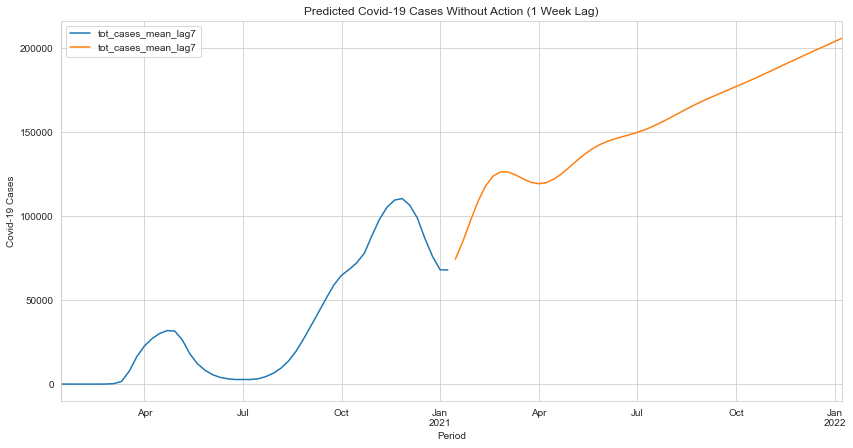

In [398]:
sns.set_style('whitegrid')
pd.concat([total_sales_on.tot_cases_mean_lag7, future_df_on.tot_cases_mean_lag7], axis=1).plot(figsize=(14, 7),title='Predicted Covid-19 Cases Without Action (1 Week Lag)',ylabel='Covid-19 Cases');

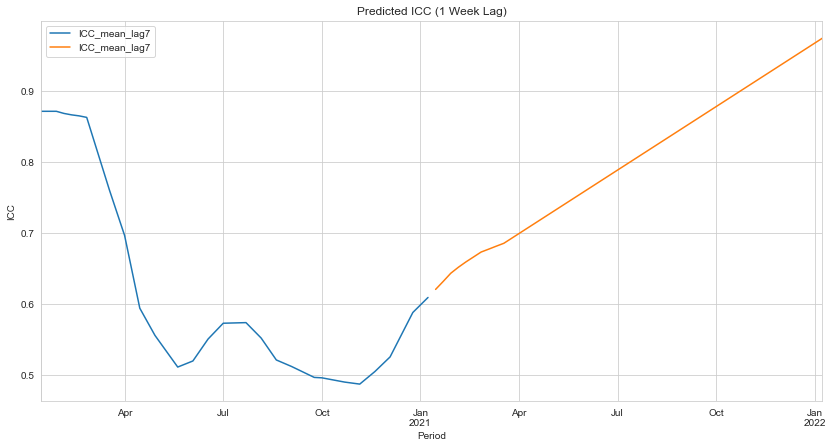

In [230]:
pd.concat([total_sales_on.ICC_mean_lag7, future_df_on.ICC_mean_lag7], axis=1).plot(figsize=(14, 7),title='Predicted ICC (1 Week Lag)', ylabel='ICC');

#### Final Forecast Online

In [439]:
model_fbp = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True, changepoint_prior_scale=2, seasonality_mode='additive', seasonality_prior_scale=0.5)
model_fbp.add_country_holidays(country_name='Spain')
for feature in selected_features2:
    model_fbp.add_regressor(feature)

model_fbp.fit(total_sales_on[["Period", "VENTAS_VALOR_ONLINE"] + selected_features2].rename(columns={"Period": "ds", "VENTAS_VALOR_ONLINE": "y"}))

forecast = model_fbp.predict(future_df_on[["Period"] + selected_features2].rename(columns={"Period": "ds"}))
future_df_on["Forecast_Prophet"] = forecast.yhat.values
interval_low_p = forecast.yhat_lower
interval_high_p = forecast.yhat_upper

In [443]:
model = auto_arima(total_sales_on.VENTAS_VALOR_ONLINE, exogenous=total_sales_on[selected_features2], trace=True, 
                   error_action="ignore", suppress_warnings=True, seasonality=True)
model.fit(total_sales_on.VENTAS_VALOR_ONLINE, exogenous=total_sales_on[selected_features2])

forecast, interval = model.predict(n_periods=len(future_df_on), exogenous=future_df_on[selected_features2], return_conf_int=True,alpha=0.05)
future_df_on["Forecast_ARIMAX"] = forecast

interval_low_a = [item[0] for item in interval]
interval_high_a = [item[1] for item in interval]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1294.730, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1417.727, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1290.829, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1401.017, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1622.025, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1291.326, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1292.092, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1293.447, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1288.083, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1288.888, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1289.181, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1434.830, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1291.522, Time=0.14 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.867 seconds


#### Combined

In [445]:
future_df_on['Combind_Prophet_ARIMAX'] = (future_df_on.Forecast_ARIMAX + future_df_on.Forecast_Prophet) / 2
con_low = (interval_low_p + interval_low_a) / 2
con_high = (interval_high_p + interval_high_a) / 2

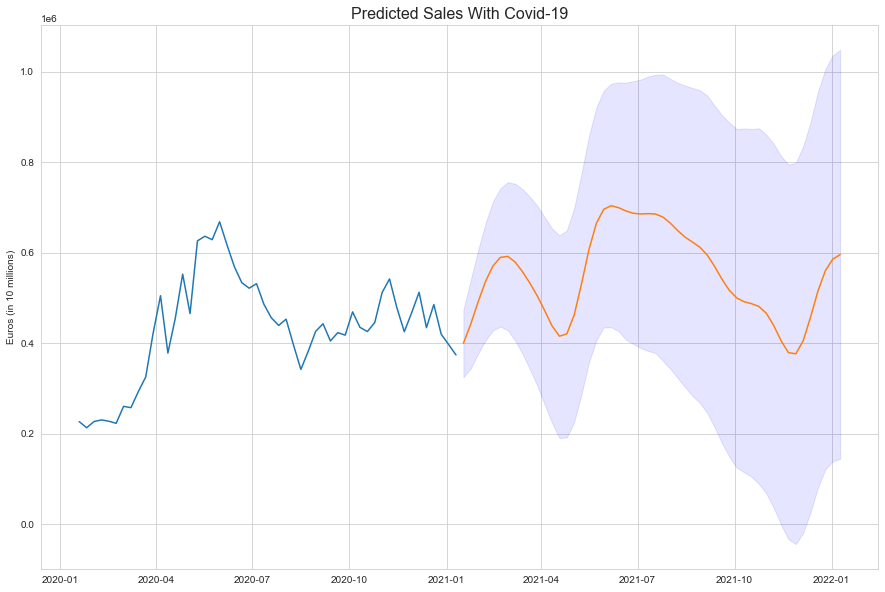

In [446]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15,10))
ax.fill_between(future_df_on.index, con_low, con_high, color='b', alpha=.1)
ax.plot(pd.concat([total_sales_on.VENTAS_VALOR_ONLINE, future_df_on.Combind_Prophet_ARIMAX], axis=1))
plt.ylabel('Euros (in 10 millions)')
plt.title('Predicted Sales With Covid-19',fontsize=16);

##### NO COVID

In [493]:
# PROPHET tot
model_fbp = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True, changepoint_prior_scale=0.5, seasonality_mode='additive')
model_fbp.add_country_holidays(country_name='Spain')

model_fbp.fit(total_sales_on[["Period", "VENTAS_VALOR_ONLINE"]].rename(columns={"Period": "ds", "VENTAS_VALOR_ONLINE": "y"}))

forecast = model_fbp.predict(future_df_on[["Period"]].rename(columns={"Period": "ds"}))
future_df_on["Forecast_Prophet_no_covid"] = forecast.yhat.values
interval_low_p = forecast.yhat_lower
interval_high_p = forecast.yhat_upper

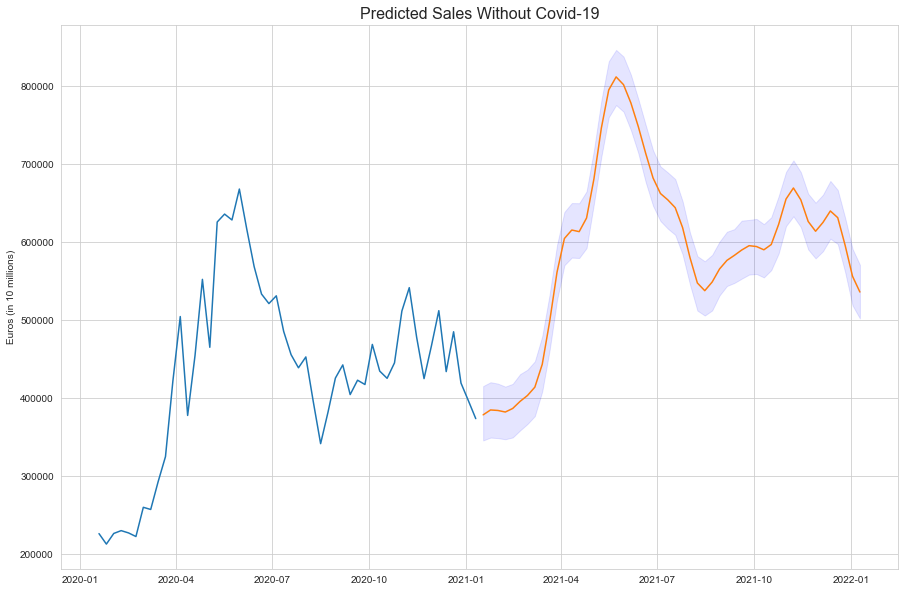

In [494]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15,10))
ax.fill_between(future_df_on.index, interval_low_p, interval_high_p, color='b', alpha=0.1)
ax.plot(pd.concat([total_sales_on.VENTAS_VALOR_ONLINE, future_df_on.Forecast_Prophet_no_covid], axis=1))
plt.ylabel('Euros (in 10 millions)')
plt.title('Predicted Sales Without Covid-19',fontsize=16);

In [499]:
model = auto_arima(total_sales_on.VENTAS_VALOR_ONLINE, trace=True, 
                   error_action="ignore", suppress_warnings=True, seasonality=True, m=12)
model.fit(total_sales_on.VENTAS_VALOR_ONLINE)

forecast2, interval2 = model.predict(n_periods=len(future_df_on), return_conf_int=True,alpha=0.05)
future_df_on["Forecast_ARIMAX_no_covid"] = forecast2

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1286.727, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1363.097, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1282.896, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1327.866, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1502.728, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1284.714, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1284.891, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1284.746, Time=0.12 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1283.254, Time=0.03 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=1286.651, Time=0.28 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1364.600, Time=0.03 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1283.452, Time=0.11 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=1284.134, Time=0.15 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1330.138, Time=0.10 sec
 ARIMA(2,0,1)(1,0,0

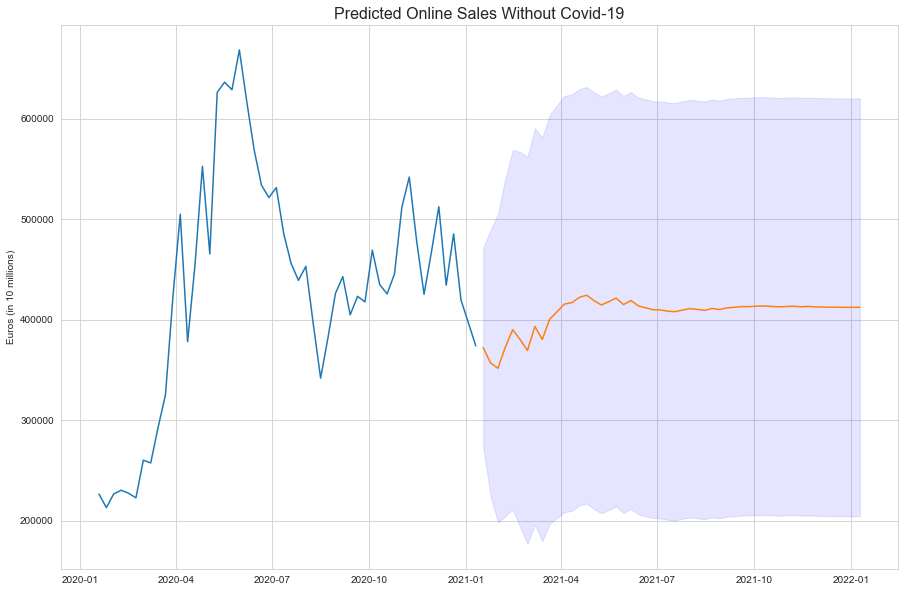

In [500]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15,10))
ax.fill_between(future_df.index, [item[0] for item in interval2], [item[1] for item in interval2], color='b', alpha=.1)
ax.plot(pd.concat([total_sales_on.VENTAS_VALOR_ONLINE, future_df_on.Forecast_ARIMAX_no_covid], axis=1))
plt.ylabel('Euros (in 10 millions)')
plt.title('Predicted Online Sales Without Covid-19',fontsize=16);

#### Combined

In [501]:
future_df_on['Combind_Prophet_ARIMAX_no_covid'] = (future_df_on.Forecast_ARIMAX_no_covid + future_df_on.Forecast_Prophet_no_covid) / 2
con_low = (interval_low_p + interval_low_a) / 2
con_high = (interval_high_p + interval_high_a) / 2

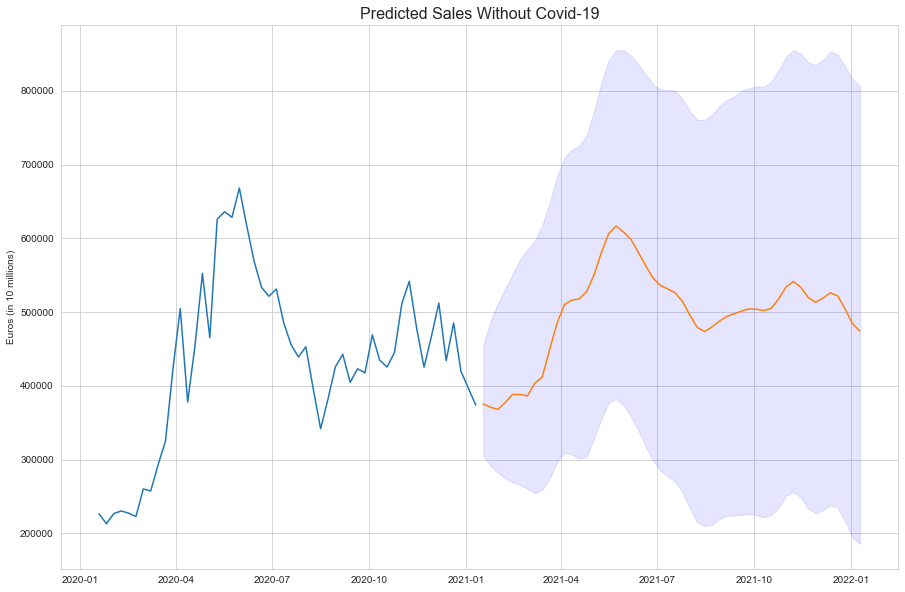

In [502]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15,10))
ax.fill_between(future_df_on.index, con_low, con_high, color='b', alpha=.1)
ax.plot(pd.concat([total_sales_on.VENTAS_VALOR_ONLINE, future_df_on.Combind_Prophet_ARIMAX_no_covid], axis=1))
plt.ylabel('Euros (in 10 millions)')
plt.title('Predicted Sales Without Covid-19',fontsize=16);

#### In Numbers

In [503]:
quarterly_forecast = future_df_on.groupby(future_df_on.index.to_period('Q')).agg(
    {'Combind_Prophet_ARIMAX':'sum'})
quarterly_forecast.Combind_Prophet_ARIMAX[0] = quarterly_forecast.Combind_Prophet_ARIMAX[0] + sum(total_sales_on.VENTAS_VALOR_ONLINE.tail(2).values)
quarterly_forecast.head(4)

,Combind_Prophet_ARIMAX
Period,
2021Q1,6.567790e+06
2021Q2,7.490043e+06
2021Q3,8.143010e+06
2021Q4,5.965705e+06


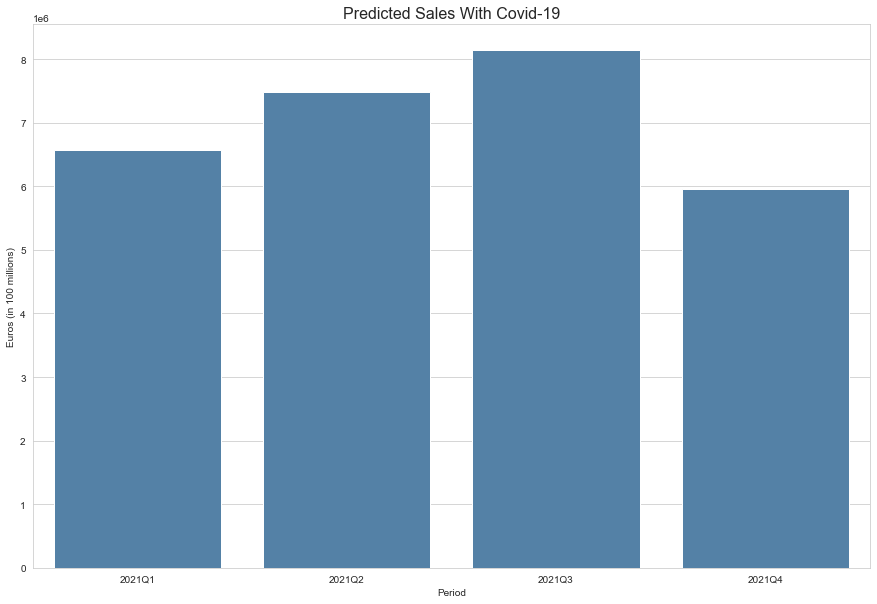

In [504]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=quarterly_forecast.head(4), x=quarterly_forecast.head(4).index, y='Combind_Prophet_ARIMAX', color='steelblue')
plt.ylabel('Euros (in 100 millions)')
plt.title('Predicted Sales With Covid-19',fontsize=16);

In [505]:
yearly_forecast = sum(quarterly_forecast.head(4)['Combind_Prophet_ARIMAX'])
np.round(yearly_forecast)

28166548.0

In [506]:
# Previous Year (2020)
sum(total_sales_on.VENTAS_VALOR_ONLINE)

22486860.0

In [507]:
# Percent Increase
print(np.round((np.round(yearly_forecast - sum(total_sales_on.VENTAS_VALOR_ONLINE))) * 100 / sum(total_sales_on.VENTAS_VALOR_ONLINE),1),'% increase from 2020')

25.3 % increase from 2020


In [508]:
# Without Covid
quarterly_forecast2 = future_df_on.groupby(future_df_on.index.to_period('Q')).agg(
    {'Combind_Prophet_ARIMAX_no_covid':'sum'})
quarterly_forecast2.Combind_Prophet_ARIMAX_no_covid[0] = quarterly_forecast2.Combind_Prophet_ARIMAX_no_covid[0] + sum(total_sales_on.VENTAS_VALOR_ONLINE.tail(2).values)
quarterly_forecast2.head(4)

,Combind_Prophet_ARIMAX_no_covid
Period,
2021Q1,5.177219e+06
2021Q2,7.324774e+06
2021Q3,6.523158e+06
2021Q4,6.744188e+06


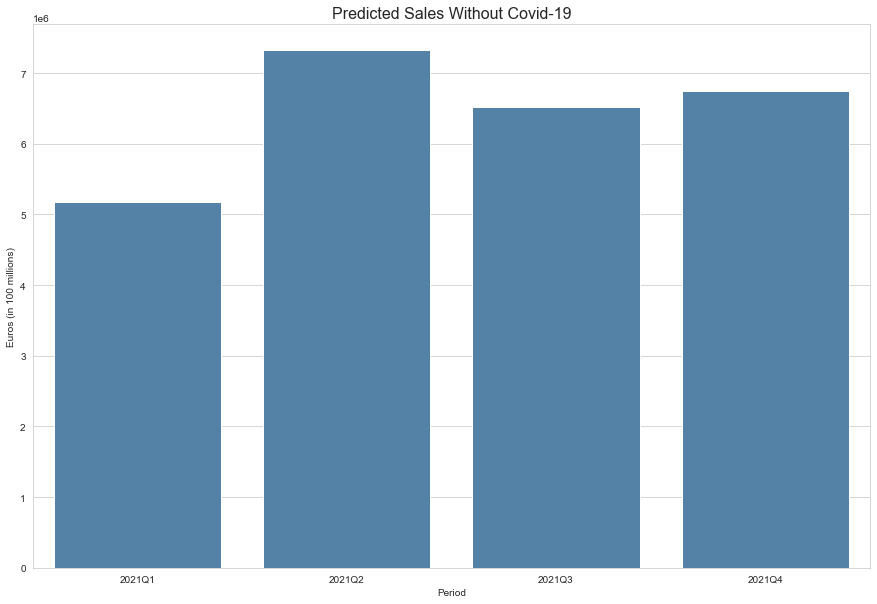

In [509]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=quarterly_forecast2.head(4), x=quarterly_forecast2.head(4).index, y='Combind_Prophet_ARIMAX_no_covid', color='steelblue')
plt.ylabel('Euros (in 100 millions)')
plt.title('Predicted Sales Without Covid-19',fontsize=16);

In [512]:
yearly_forecast2 = sum(quarterly_forecast2.head(4)['Combind_Prophet_ARIMAX_no_covid'])
print('Yearly forecast:',np.round(yearly_forecast2))

# Percent Increase
print(np.round((np.round(yearly_forecast2 - sum(total_sales_on.VENTAS_VALOR_ONLINE))) * 100 / sum(total_sales_on.VENTAS_VALOR_ONLINE),1),'% increase from 2020')

Yearly forecast: 25769339.0
14.6 % increase from 2020
